**Make sure the train, test and stacked files are present in your session.**

In [ ]:
!pip install raster2xyz
!apt install gdal-bin python-gdal python3-gdal 
!pip install rasterio
!pip install rotation-forest

In [ ]:
import pandas as pd 

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,class,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10
0,1,0.42265,0.0,0.0,0.39646,0.0,2.31381,0.0,0.0,1.0,0.12136
1,1,0.40946,0.0,0.0,0.39661,0.0,2.31462,0.0,0.0,1.0,0.02162
2,1,0.42254,0.0,0.0,0.40061,0.0,2.33671,0.0,0.0,1.0,0.02381
3,1,0.41098,0.0,0.0,0.38373,0.0,2.24535,0.0,0.0,1.0,-0.11111
4,1,0.34910,0.0,0.0,0.37910,0.0,2.22111,0.0,0.0,1.0,-0.11962


In [ ]:
test.head()

,class,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10
0,1,0.40276,0.0,0.0,0.39486,0.0,2.30499,0.0,0.0,1.0,0.02010
1,1,0.34585,0.0,0.0,0.40878,0.0,2.38284,0.0,0.0,1.0,-0.16111
2,1,0.44139,0.0,0.0,0.40153,0.0,2.34188,0.0,0.0,1.0,0.03015
3,1,0.31965,0.0,0.0,0.35112,0.0,2.08224,0.0,0.0,1.0,0.08300
4,1,0.19065,0.0,0.0,0.35311,0.0,2.09170,0.0,0.0,1.0,0.15094


In [ ]:
train_x = train[train.columns[1:]]
train_y = train[train.columns[0]]

In [ ]:
test_x = test[test.columns[1:]]
test_y = test[test.columns[0]]

In [ ]:
from rotation_forest import RotationForestClassifier as rfc

clf = rfc()
clf.fit(train_x, train_y)

In [ ]:
print('Accuracy :',clf.score(test_x, test_y))

Accuracy : 0.8433333333333334


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train_x, train_y)
print('Accuracy :',clf.score(test_x, test_y))

0.8994444444444445

In [ ]:
from raster2xyz.raster2xyz import Raster2xyz

rtxyz = Raster2xyz()
fp = 'stacked.tif'
rtxyz.translate(fp, 'stacked.csv')

[2020-12-13 01:50:10 - INFO] - Getting geotransform and data...
[2020-12-13 01:50:10 - INFO] - Getting XYZ data...
[2020-12-13 01:50:10 - INFO] - Getting geotransformed coordinates...
[2020-12-13 01:50:10 - INFO] - Building XYZ data...
[2020-12-13 01:50:20 - INFO] - New XYZ (csv file) created...


In [ ]:
stack = pd.read_csv('stacked.csv')
stack.head()

,x,y,z
0,602935.0,4597675.0,-0.010063
1,602945.0,4597675.0,-0.029860
2,602955.0,4597675.0,-0.023508
3,602965.0,4597675.0,-0.030303
4,602975.0,4597675.0,-0.012270


[2020-12-13 01:50:22 - WARNING] - CPLE_AppDefined in TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
[2020-12-13 01:50:23 - WARNING] - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


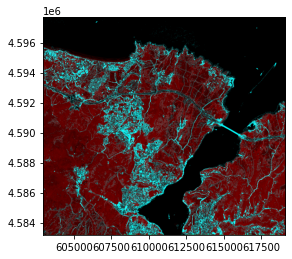

In [ ]:
import rasterio
from rasterio.plot import show

img = rasterio.open(fp)
show(img)

In [ ]:
import gdal
import numpy as np

driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(fp)
nbands = naip_ds.RasterCount
data = np.empty((naip_ds.RasterXSize*naip_ds.RasterYSize, nbands))
for i in range(1, nbands+1):
    band = naip_ds.GetRasterBand(i).ReadAsArray()
    data[:, i-1] = band.flatten()

In [ ]:
df = pd.DataFrame(data)

In [ ]:
predictions = clf.predict(df)

In [ ]:
stack = pd.concat([stack, pd.Series(predictions)],axis=1,sort=False)
stack.columns = ['x','y','z','class']
stack.head()

,x,y,z,class
0,602935.0,4597675.0,-0.010063,4
1,602945.0,4597675.0,-0.029860,4
2,602955.0,4597675.0,-0.023508,4
3,602965.0,4597675.0,-0.030303,4
4,602975.0,4597675.0,-0.012270,4


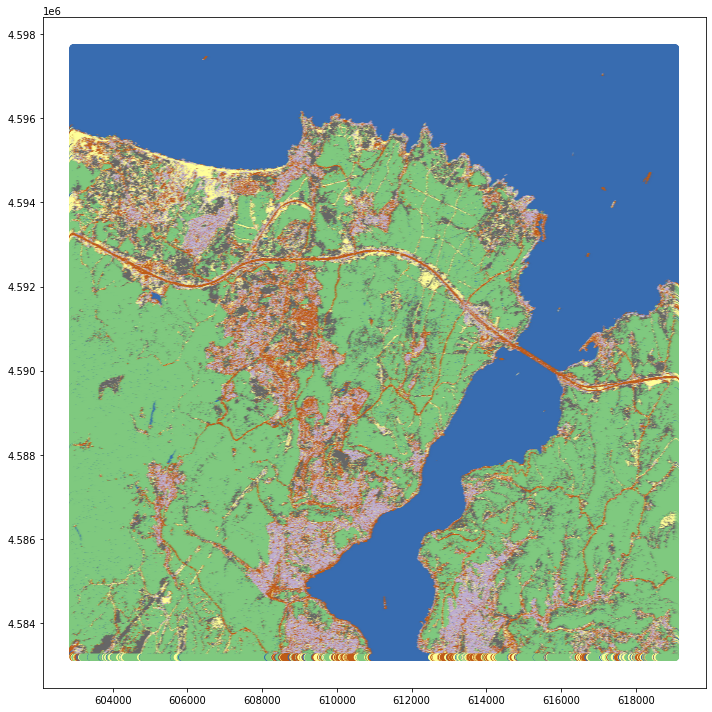

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.scatter(stack['x'] , stack['y'], c=stack['class'], cmap = 'Accent')
plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image
from io import BytesIO
png1 = BytesIO()
fig.savefig(png1, format='png')
png2 = Image.open(png1)
png2.save('result.tif')
png1.close()